## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'DF'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-47.88390,-15.94640,1090.540,978079.15,978084.087938,-4.937938
1,-47.70620,-15.61470,948.380,978102.50,978110.498332,-7.998332
2,-47.62030,-15.94020,1014.590,978098.25,978096.666024,1.583976
3,-47.60140,-15.94610,1041.930,978092.48,978090.176684,2.303316
4,-47.54430,-15.54550,1155.080,978059.68,978049.243258,10.436742
...,...,...,...,...,...,...
287,-47.80082,-16.01977,869.761,978125.40,978132.899213,-7.499213
288,-47.87819,-15.94865,1103.238,978075.26,978080.015542,-4.755542
289,-47.87698,-15.94780,1101.081,978075.98,978080.644251,-4.664251
290,-47.88426,-15.94619,1090.005,978079.22,978084.256278,-5.036278


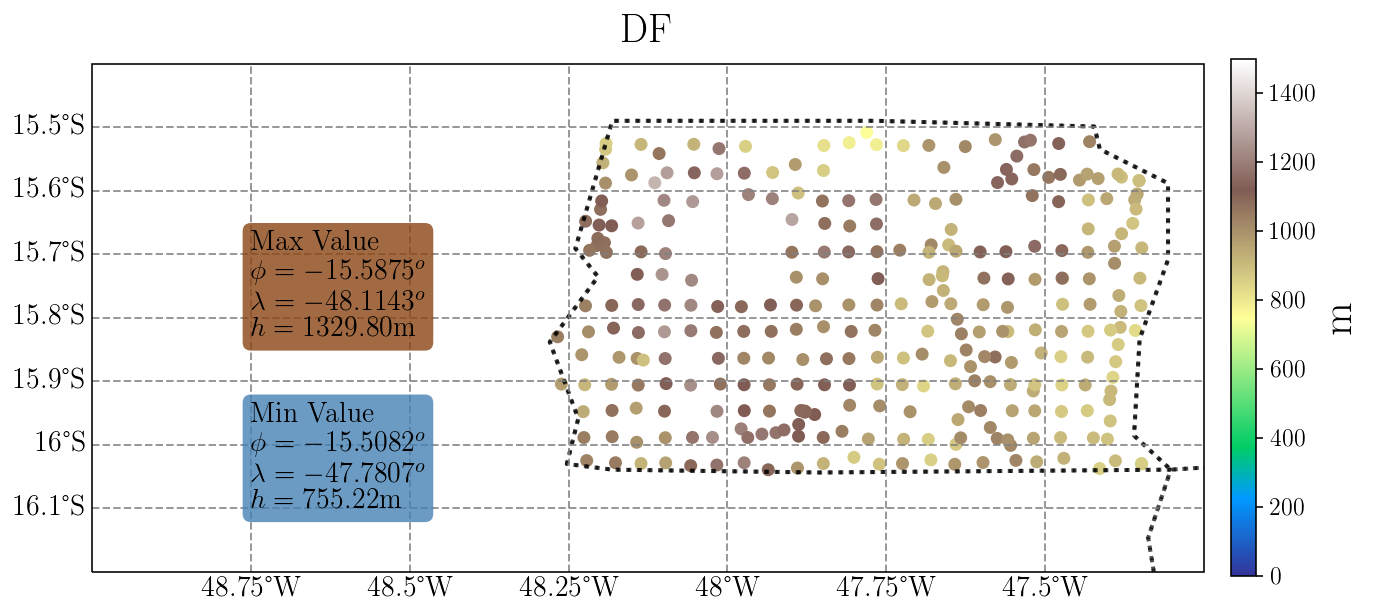

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-49,-47.25,-16.2,-15.4], \
          sign=(-48.75,-48.75,-15.83,-16.1), cmap='terrain', lim_val=(True,True,0.,1500.), shrink=0.34)

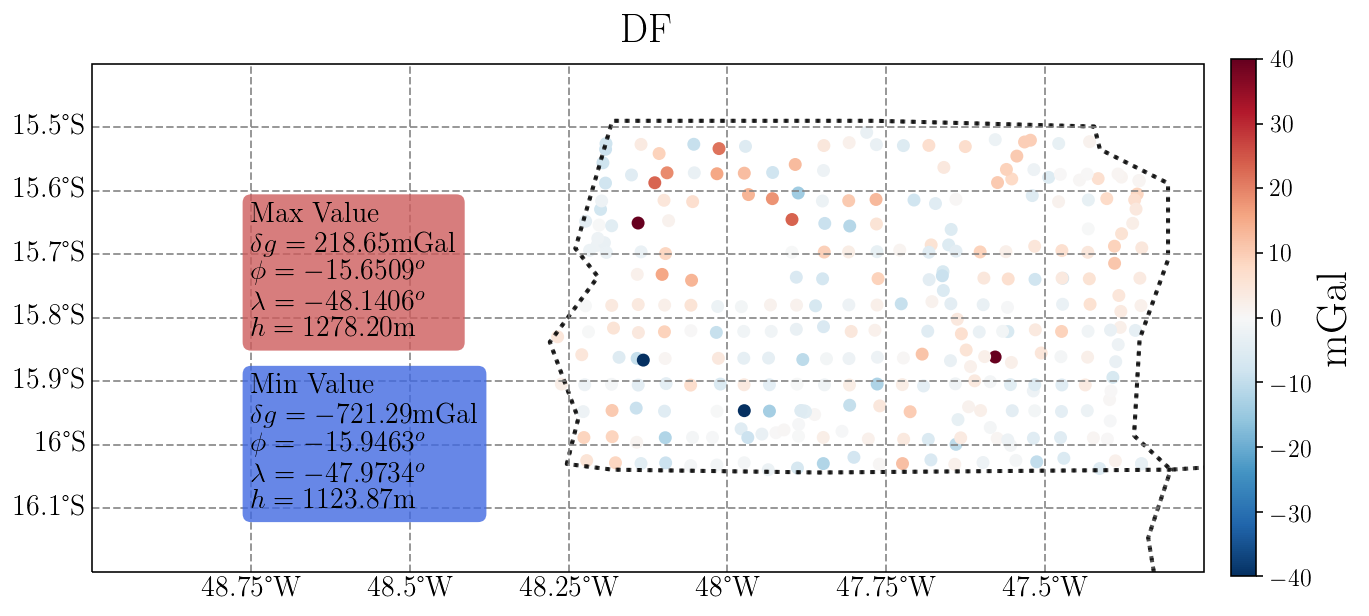

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-49,-47.25,-16.2,-15.4], \
          sign=(-48.75,-48.75,-15.83,-16.1), lim_val=(True, 40.), shrink=0.34)

In [8]:
index = np.argmax(df.ALT.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.ALT.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 272 1329.8039999999999 23.302254099980928
MIN 90 755.22 -3.041835599928163


In [9]:
index_max = np.argmax(df.DIST.values)
print('MAX', index, df.ALT[index], df.DIST[index_max])

index_min = np.argmin(df.DIST.values)
print('MIN', index, df.ALT[index], df.DIST[index_min])

MAX 90 755.22 218.65428779996
MIN 90 755.22 -721.2949605999747


In [10]:
disturb = np.delete(df.DIST.values, [index_min, index_max])
longitude = np.delete(df.LONG.values, [index_min, index_max])
latitude = np.delete(df.LAT.values, [index_min, index_max])
altitude = np.delete(df.ALT.values, [index_min, index_max])

### Calculating rotation matrices and Cartesian coordinates

In [11]:
# Calculating Cartesian coordinates
# x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
# R = np.array(rotation_matrix(df.LONG, df.LAT))
x, y, z = geodetic2cartesian(longitude, latitude, altitude)
R = np.array(rotation_matrix(longitude, latitude))

## Estimating the first set of point-mass parameters

In [12]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [13]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [14]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

# latcl = df.LAT[indl]
# loncl = df.LONG[indl]
latcl = latitude[indl]
loncl = longitude[indl]

In [15]:
Rcl = R[:, indl]

In [16]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(longitude, latitude, np.zeros_like(longitude)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(290, 290)


In [17]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [18]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

290


In [19]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [20]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

0.2139860385486827

In [21]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [22]:
rabs_max.append(rabs_max_l)

In [23]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

0.2139860385486827


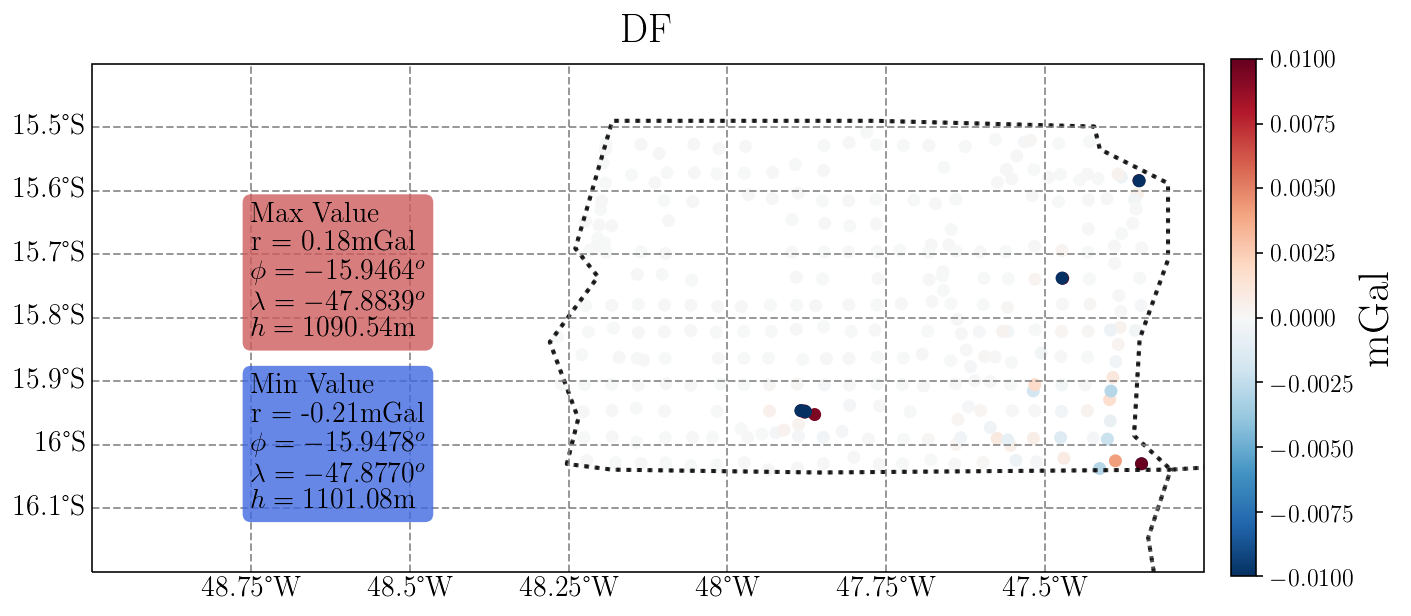

In [24]:
point_map(longitude, latitude, altitude, rc, uf, fig_size=(12.,14.), region=[-49,-47.25,-16.2,-15.4], \
          sign=(-48.75,-48.75,-15.83,-16.1), shrink=0.34, residual=True, lim_val=(True, 1e-2))

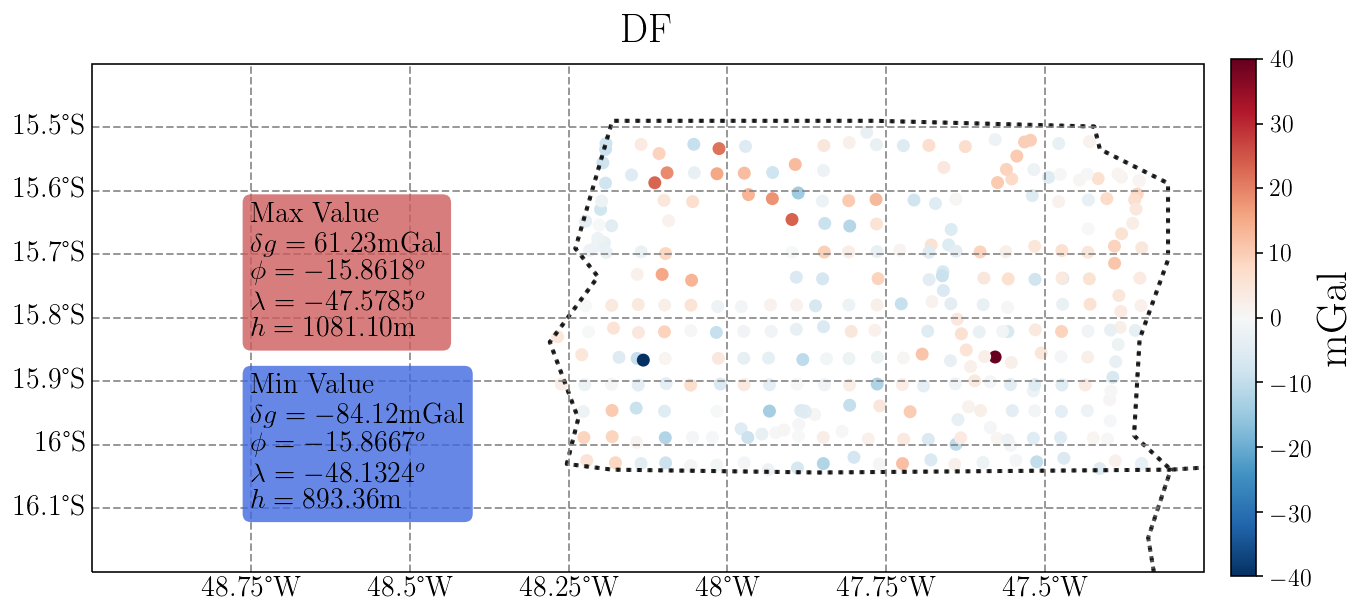

In [25]:
point_map(longitude, latitude, altitude, disturb, uf, fig_size=(12.,14.), region=[-49,-47.25,-16.2,-15.4], \
          sign=(-48.75,-48.75,-15.83,-16.1), shrink=0.34, lim_val=(True, 40.))

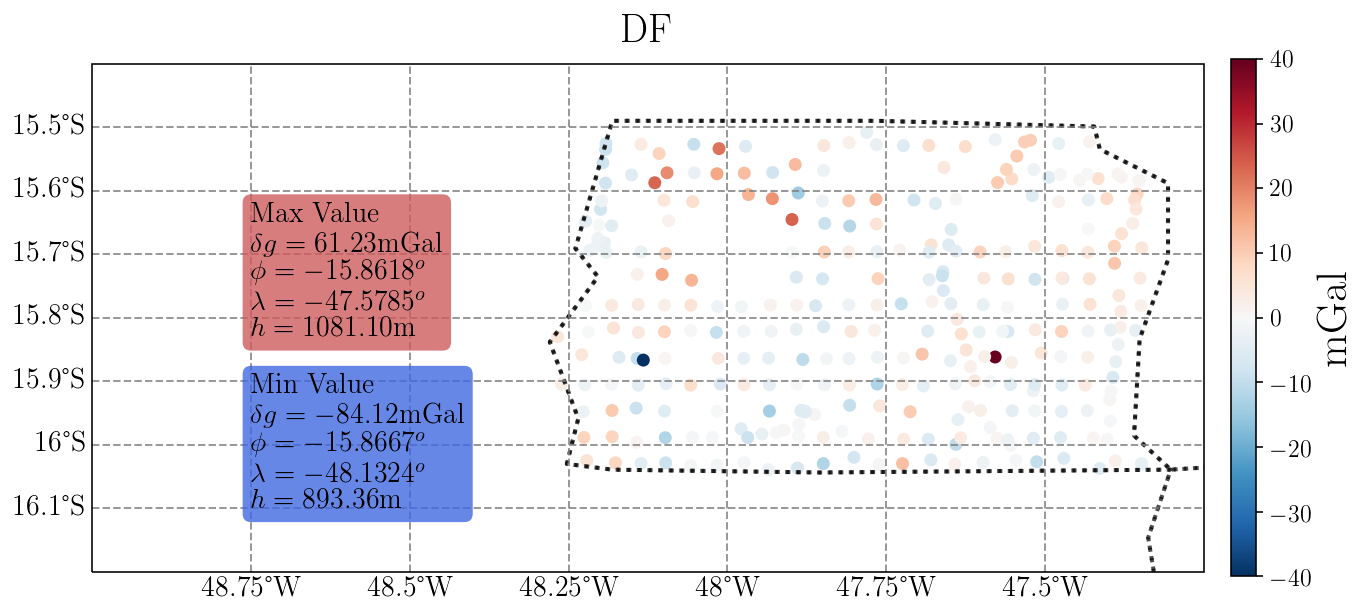

In [26]:
point_map(longitude, latitude, altitude, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), \
          region=[-49,-47.25,-16.2,-15.4], sign=(-48.75,-48.75,-15.83,-16.1), shrink=0.34, lim_val=(True, 40.))

In [27]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [28]:
new_data = {'LONG':longitude, \
            'LAT':latitude, \
            'ALT':altitude, \
            'BDG':np.delete(bdg.GRAV.values,[index_min, index_max]), \
            'EIGEN':np.delete(eigen.GRAV.values,[index_min, index_max]), \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-47.88390,-15.94640,1090.540,978079.15,978084.087938,-4.937938,-3.590570e+15,1.813823e-01
1,-47.70620,-15.61470,948.380,978102.50,978110.498332,-7.998332,-5.773356e+12,-6.651190e-07
2,-47.62030,-15.94020,1014.590,978098.25,978096.666024,1.583976,2.779412e+12,-1.213106e-04
3,-47.60140,-15.94610,1041.930,978092.48,978090.176684,2.303316,2.405895e+12,1.800337e-04
4,-47.54430,-15.54550,1155.080,978059.68,978049.243258,10.436742,6.760897e+12,3.964840e-05
...,...,...,...,...,...,...,...,...
285,-47.80082,-16.01977,869.761,978125.40,978132.899213,-7.499213,-4.196248e+12,2.640094e-05
286,-47.87819,-15.94865,1103.238,978075.26,978080.015542,-4.755542,-7.077640e+14,6.653736e-02
287,-47.87698,-15.94780,1101.081,978075.98,978080.644251,-4.664251,2.545290e+15,-2.139860e-01
288,-47.88426,-15.94619,1090.005,978079.22,978084.256278,-5.036278,3.894580e+15,-2.123221e-01


In [29]:
print(df.RESID.min(), df.RESID.max())

-0.2139860385486827 0.18138230999102234


### Upward Continuation

In [30]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [31]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


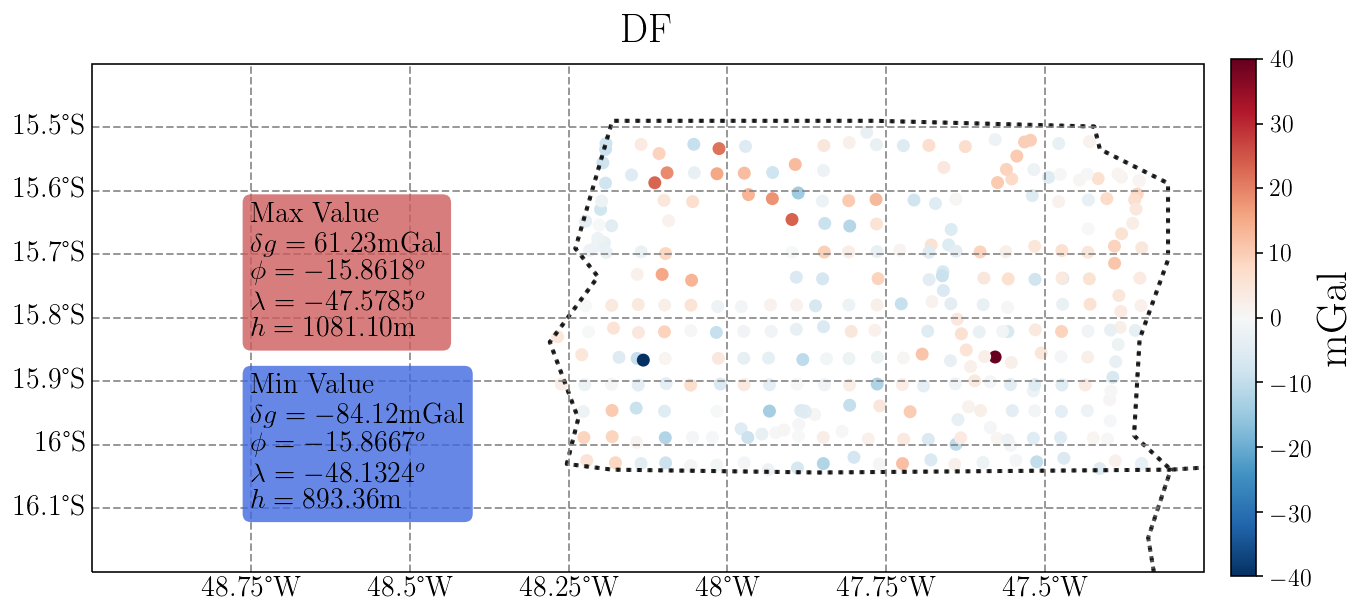

In [32]:
point_map(df.LONG, df.LAT, df.ALT, disturb, uf, fig_size=(12.,14.), region=[-49,-47.25,-16.2,-15.4], \
          sign=(-48.75,-48.75,-15.83,-16.1), shrink=0.34, lim_val=(True, 40.))

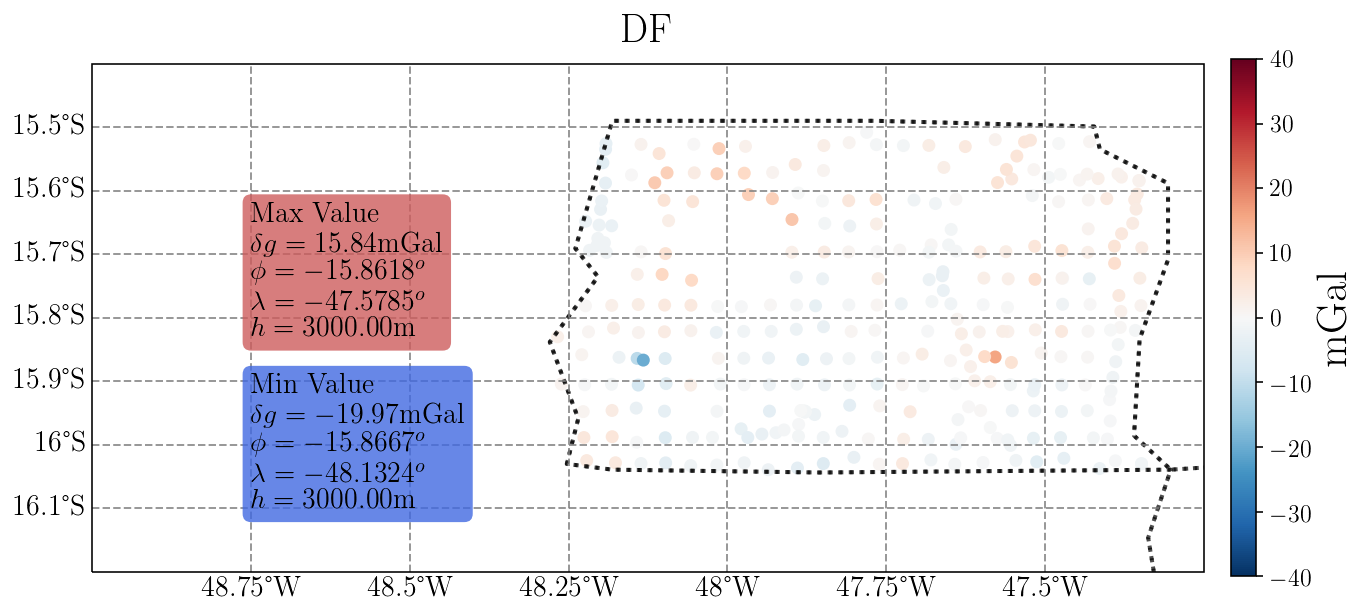

In [33]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-49,-47.25,-16.2,-15.4], sign=(-48.75,-48.75,-15.83,-16.1), shrink=0.34, lim_val=(True, 40.))

In [34]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG, df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


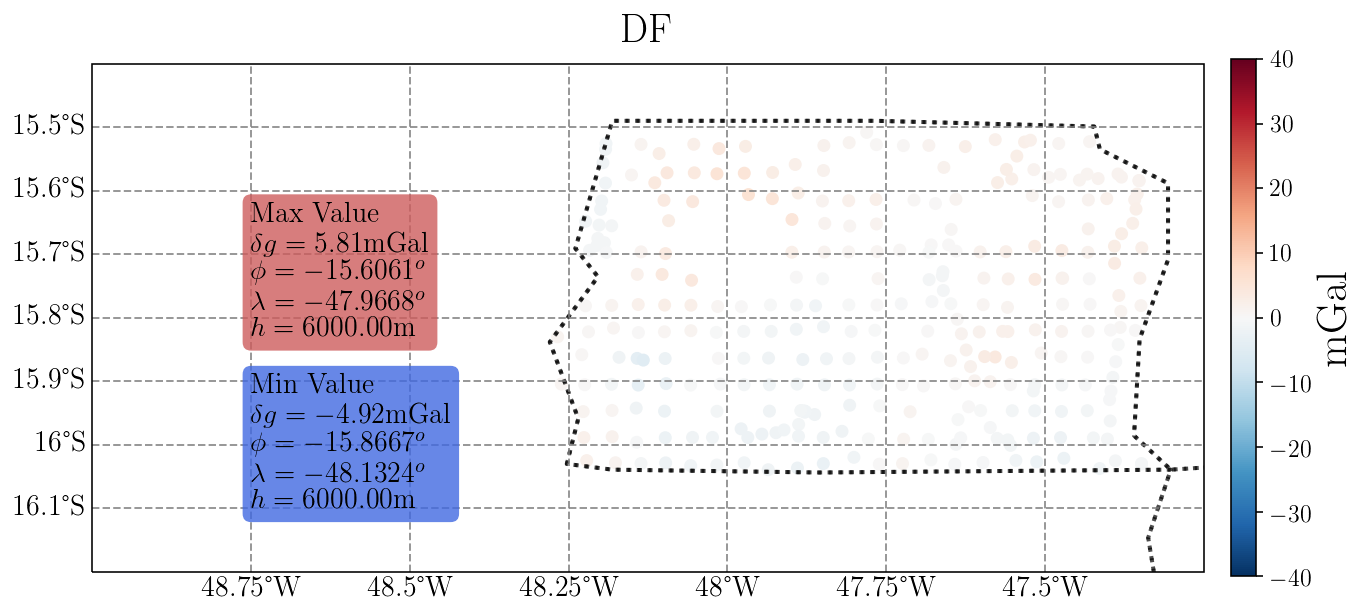

In [35]:
point_map(longitude, latitude, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-49,-47.25,-16.2,-15.4], sign=(-48.75,-48.75,-15.83,-16.1), shrink=0.34, lim_val=(True, 40.))

In [36]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


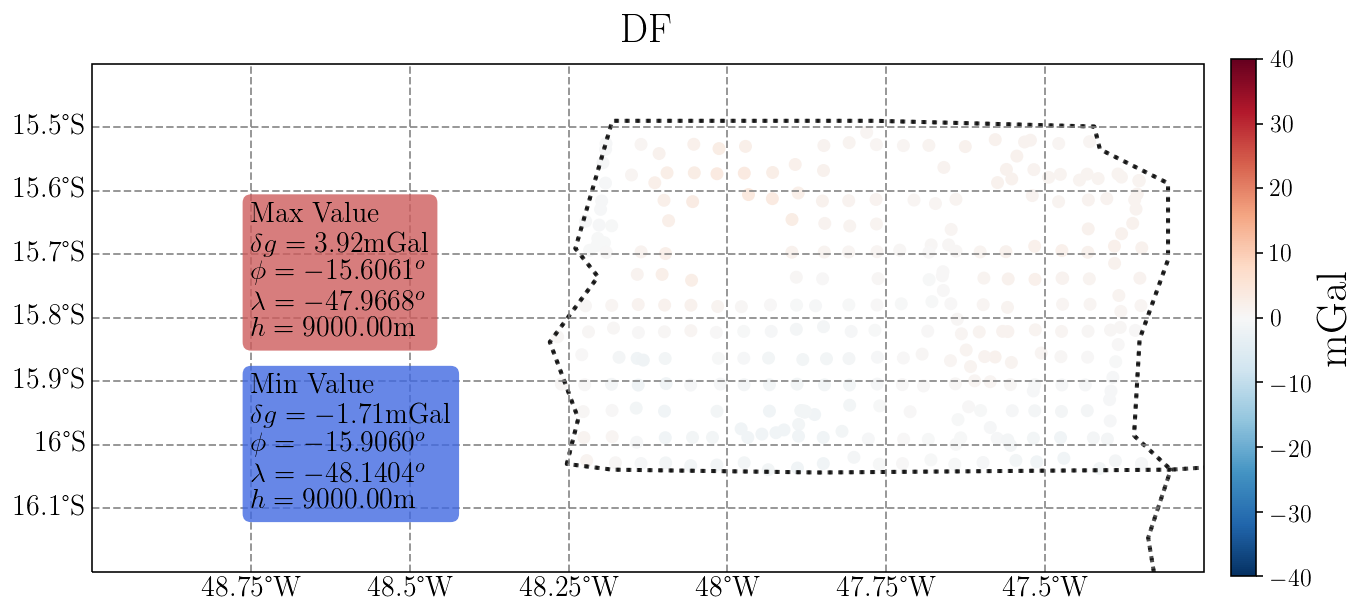

In [37]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-49,-47.25,-16.2,-15.4], sign=(-48.75,-48.75,-15.83,-16.1), shrink=0.34, lim_val=(True, 40.))